# TODO Add markdown structure like in other notebooks

This notebook is for sanity. In specific to get the absolute and relative failure rate

In [1]:
import polars as pl
from data_io.loader.data_loader import DataLoader
import matplotlib.pyplot as plt
from analysis.sanity.sanity_helpers import station_outage_rate

dl = DataLoader()

Get the absolute and relative failure rate data of every station

In [2]:
outages = station_outage_rate(dl)
pl.Config.set_tbl_rows(100)
outages

station,start,end,expected_hours,missing_hours,outage_rate
str,i64,i64,i64,i64,f64
"""Ziegelhäuser Landstraße""",2019,2025,59645,24747,0.414905
"""Schlierbacher Landstraße""",2019,2025,60216,23915,0.397154
"""Bahnstadtpromenade""",2020,2025,47151,16757,0.35539
"""Hardtstraße""",2020,2025,51456,10549,0.20501
"""Plöck""",2015,2025,88728,7563,0.085238
"""Kurfürstenanlage Querschnitt""",2019,2025,60216,4888,0.081174
"""Berliner Straße Querschnitt""",2020,2025,51456,3944,0.076648
"""Eppelheimer Str. Querschnitt""",2020,2025,51456,2223,0.043202
"""Liebermannstraße""",2018,2025,62929,1571,0.024965


Plot the failure rate data of the output table above

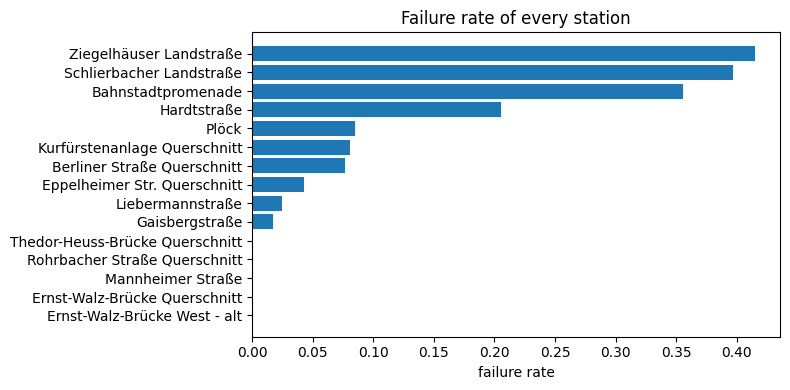

In [3]:
df = outages.sort("outage_rate", descending=True)

plt.figure(figsize=(8, max(4, 0.25 * df.height)))
plt.barh(df["station"], df["outage_rate"])
plt.xlabel("failure rate")
plt.title("Failure rate of every station")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

We may need to look more closely...

In [21]:
import plotly.graph_objs as go

start, end = "2018-01-01", "2024-12-31"
fig = go.Figure()

# dl.get_bicyle_stations()
for station in ['Plöck', 'Mannheimer Straße', 'Schlierbacher Landstraße']:
    bd = dl.get_bicycle(station_name=station, interval=(start, end), sample_rate="1d")
    df = bd.df
    if df.is_empty():
        continue
    fig.add_trace(
        go.Scatter(
            x=df["datetime"].to_numpy(),
            y=df["channels_all"].to_numpy(),
            name=station,
            line=dict(width=1)
        )
    )

fig.update_layout(
    title="Daily Amount of Cyclist per Station (2022)",
    xaxis_title="Date",
    yaxis_title="Number Cyclists",
    legend_title="Station",
    height=600,
    width=1000
)
fig.show()

Schlierbacher Landstraße looks strange, let's take a deeper look...

In [24]:
import plotly.graph_objs as go

station = "Plöck"

bd = dl.get_bicycle(station_name=station, interval=(start, end), sample_rate="1d")
df = bd.df

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=df["datetime"].to_numpy(),
        y=df["channels_all"].to_numpy(),
        name=station
    )
)

fig.update_layout(
    title=f"Daily cyclists at: {station} (2022)",
    xaxis_title="Date",
    yaxis_title="Number of Cyclists",
    height=400,
    width=900
)
fig.show()

Are some failing stations consistenly reporting zero cyclist? Plöck looks suspicious... Let's lock closer between August and September 2021... 

In [32]:
start, end = "2021-08-01", "2021-09-30"
bd = dl.get_bicycle(station_name=station, interval=(start, end), sample_rate="1d")
df = bd.df

print(len(df))

print(df)

0
shape: (0, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ datetime   ┆ channels_i ┆ channels_o ┆ channels_ ┆ channels_ ┆ site_temp ┆ site_rain ┆ site_snow │
│ ---        ┆ n          ┆ ut         ┆ all       ┆ unknown   ┆ erature   ┆ _accumula ┆ _accumula │
│ datetime[μ ┆ ---        ┆ ---        ┆ ---       ┆ ---       ┆ ---       ┆ tion      ┆ tion      │
│ s, UTC]    ┆ i32        ┆ i32        ┆ i32       ┆ i32       ┆ f64       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆           ┆           ┆           ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
